In [1]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from collections import Counter
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore",module="scipy",message="^internal gelsd")

**Iterate**
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

I used the previous cleaning script. Used histogram and stats to review population and choses 125000 as max.

- *np.where(data.population >= 125000) ==> (array([ 15,  60, 203], dtype=int64),)*

previous results for NY State 2013 statistics with *X = data[['violent', 'larceny']]* ==>

-Coefficients:  [[0.78925906 1.12839734]] Intercept:  [2.99388498] R-squared: 0.9958061737773204



In [3]:
file = 'data/crimeGA.txt'
df = pd.read_csv(file,header=None)
df.columns =['city','population','violent','murder','rape1','rape','robbery','assault',
             'property','burglary','larceny','vehicletheft','arson']
df = df.drop(columns = ['rape1', 'arson'])
df = df.drop([ 15, 60, 203])
df.index =  range(len(df))
df.tail(2)

,city,population,violent,murder,rape,robbery,assault,property,burglary,larceny,vehicletheft
248,Woodstock,"25,515",20,0,3,6,11,594,47,534,13
249,Wrens,"2,096",10,0,2,1,7,79,8,71,0


In [4]:
# cleaning object columns to int
def A(df): return df.apply(lambda x: x.str.replace(r'\D', '', regex=True), axis=1)   # remove non-digits 
def B(df): return df.apply(lambda x: x.str.strip(), axis=1)                          #  strip()
def C(df): return df.apply(lambda x: int(x), axis=1)                                 # int()
# dictionary with f() as values
switch = {char:eval(char) for char in 'ABC'}
# string of letters of functions to apply
def df_cleaning(df, string):
    for char in string:
        df = switch[char](df)
    return df 

In [5]:
# df1 is cleaned columns that had dtype as object
clean_cols = ['population','violent','robbery','assault','property','burglary','larceny','vehicletheft']
series = [df_cleaning(pd.DataFrame(df[col]),'ABC') for col in clean_cols]
df1 = pd.DataFrame(series, index=clean_cols).T
df1.tail(2)

,population,violent,robbery,assault,property,burglary,larceny,vehicletheft
248,25515,20,6,11,594,47,534,13
249,2096,10,1,7,79,8,71,0


In [6]:
# data is df with cleaned columns of df1
df2 = df.drop(columns = (clean_cols + ['city']))
data = pd.concat([df2, df1], axis = 1)
data.tail(2)

,murder,rape,population,violent,robbery,assault,property,burglary,larceny,vehicletheft
248,0,3,25515,20,6,11,594,47,534,13
249,0,2,2096,10,1,7,79,8,71,0


In [7]:
#shuffle the df 
A  = np.array(range(len(data)))
np.random.shuffle(A)
data.index  = A
data = data.sort_index()

In [8]:

fts = ['population','violent','rape','robbery','assault','burglary','larceny','vehicletheft']
xs =  [list(pair) for pair in it.combinations(fts, 2)] + [list(triple) for triple in it.combinations(fts, 3)]

In [9]:
# Instantiate and fit our model.
results = []
regr = linear_model.LinearRegression()
for x in xs:
    Y = data['property'].values.reshape(-1, 1)
    X = data[x]
    regr.fit(X, Y)
    dct = {'r_squared':regr.score(X, Y), 'intercept':regr.intercept_[0] }
    dct.update({key:val for val in regr.coef_[0] for key in x})
    results.append(dct)

In [10]:
# review df with results of all regression tests
keys = ['r_squared','intercept','population','violent','rape','robbery','assault','burglary','larceny','vehicletheft' ]
review = pd.DataFrame(columns = keys)
series = [pd.Series(result) for result in results]
review = pd.concat([review, pd.concat(series, axis=1, sort=False).T], axis=0, sort=False)
review

,r_squared,intercept,population,violent,rape,robbery,assault,burglary,larceny,vehicletheft
0,0.911,9.112,6.019,6.019,nan,nan,nan,nan,nan,nan
1,0.833,42.185,87.660,nan,87.660,nan,nan,nan,nan,nan
2,0.913,44.996,16.083,nan,nan,16.083,nan,nan,nan,nan
3,0.847,-0.613,7.427,nan,nan,nan,7.427,nan,nan,nan
4,0.951,33.400,3.094,nan,nan,nan,nan,3.094,nan,nan
5,0.985,-15.111,1.482,nan,nan,nan,nan,nan,1.482,nan
6,0.861,36.874,5.944,nan,nan,nan,nan,nan,nan,5.944
7,0.900,58.785,nan,58.293,58.293,nan,nan,nan,nan,nan
8,0.881,91.833,nan,11.357,nan,11.357,nan,nan,nan,nan
9,0.898,90.175,nan,-12.681,nan,nan,-12.681,nan,nan,nan


In [11]:
review

,r_squared,intercept,population,violent,rape,robbery,assault,burglary,larceny,vehicletheft
0,0.911,9.112,6.019,6.019,nan,nan,nan,nan,nan,nan
1,0.833,42.185,87.660,nan,87.660,nan,nan,nan,nan,nan
2,0.913,44.996,16.083,nan,nan,16.083,nan,nan,nan,nan
3,0.847,-0.613,7.427,nan,nan,nan,7.427,nan,nan,nan
4,0.951,33.400,3.094,nan,nan,nan,nan,3.094,nan,nan
5,0.985,-15.111,1.482,nan,nan,nan,nan,nan,1.482,nan
6,0.861,36.874,5.944,nan,nan,nan,nan,nan,nan,5.944
7,0.900,58.785,nan,58.293,58.293,nan,nan,nan,nan,nan
8,0.881,91.833,nan,11.357,nan,11.357,nan,nan,nan,nan
9,0.898,90.175,nan,-12.681,nan,nan,-12.681,nan,nan,nan


#### Check with Folds

In [12]:
# 10% target, returns list of 10 combinations
def fold_9d_1t(df):
    assert(10 <= len(df))
    n1 = len(df) // 10; n2 = len(df) % 10    
    df.index = pd.Series([x for x in range(10)] * n1 + [x for x in range(n2)])
    # creates list of tuples ==> [(train, test), ... n times]
    xys = [(df[df.index != i], df[df.index != i]) for i in range(10)]
    return xys

In [13]:
folds = fold_9d_1t(data)
features = ['burglary','larceny','vehicletheft']
target = ['property']

In [14]:
results = []
dct = {}
regr = linear_model.LinearRegression()
for fold in folds:
    x_trn = fold[0][features]; y_trn = fold[0][target].values.reshape(-1, 1)
    x_tst = fold[1][features]; y_tst = fold[1][target].values.reshape(-1, 1)
    regr.fit(x_trn, y_trn)
    y_pred = regr.predict(x_tst)
    dct = {'r_squared':r2_score(y_tst,y_pred),'means_squared': mean_squared_error(y_tst, y_pred)}
    results.append(dct)
    

In [15]:
# review df with results of all regression tests

rev = pd.DataFrame(columns = ['r_squared', 'means_squared'])
series = [pd.Series(result) for result in results]
review = pd.concat([rev, pd.concat(series, axis=1, sort=False).T], axis=0, sort=False).T
review

,0,1,2,3,4,5,6,7,8,9
r_squared,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
means_squared,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


#### Residual Checks

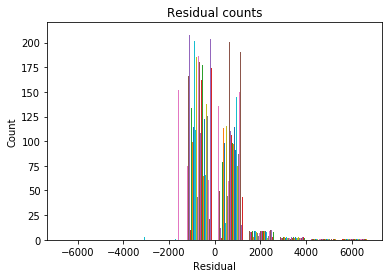

In [16]:
# Extract predicted values.
predicted = regr.predict(x_tst).ravel()
actual = y_tst
# Calculate the error, also called the residual.
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts');plt.xlabel('Residual');plt.ylabel('Count')
plt.show()

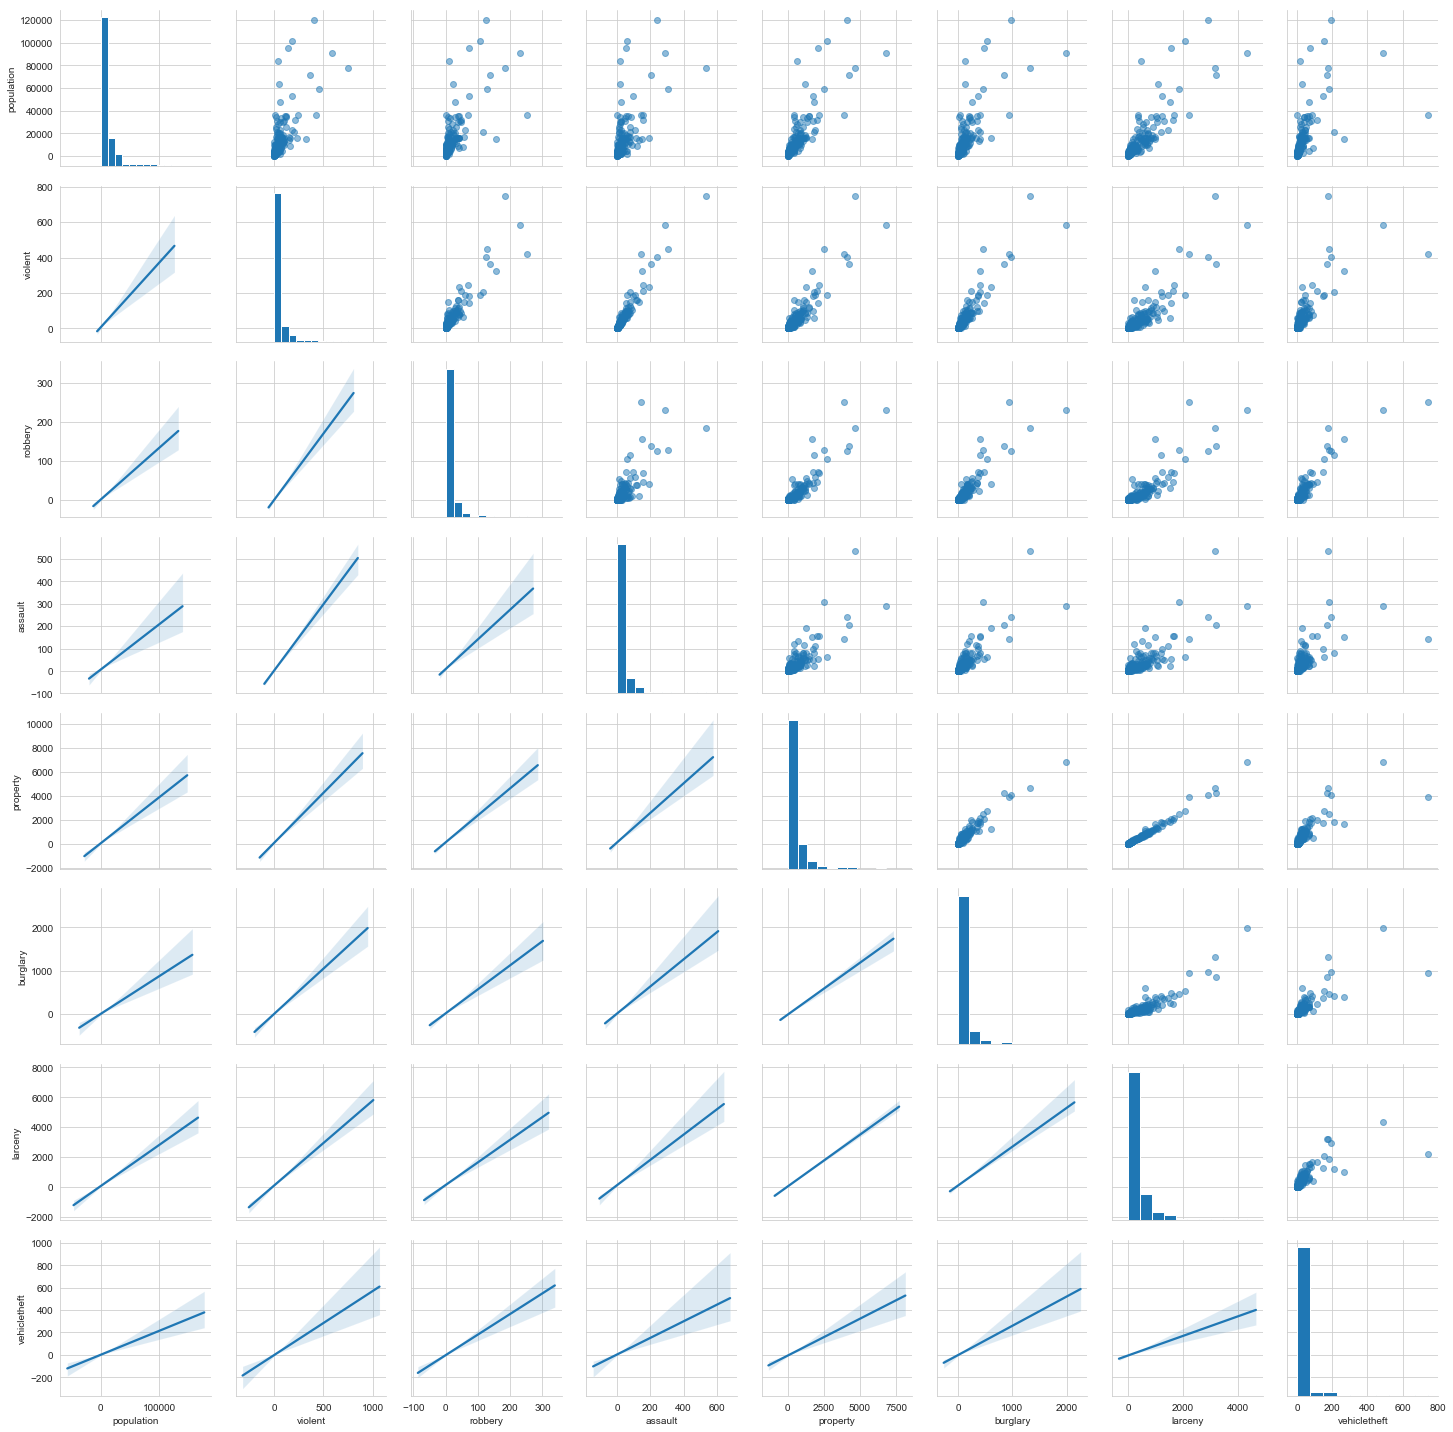

In [17]:
sns.set_style("whitegrid")
g = sns.PairGrid(df1, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(plt.hist)
plt.show()

ValueError: x and y must be the same size

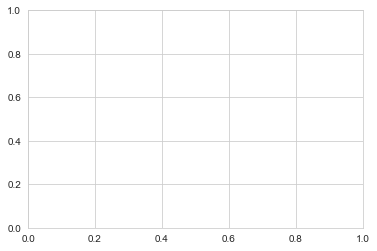

In [18]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
correlation_matrix = X.corr()
display(correlation_matrix)